# Custom networks

Observational data is often extremely complex and high dimensional. `swyft` is designed to share the processing of observational data before passing it to each marginal classifier for marginal likelihood-to-evidence ratio estimation. This can be a combination of learnable transformations along with static ones. This notebook demonstrates that techinque. We denote this part of the network the _head_.

In this example, we aim to estimate the $x$ and $y$ coordinates and radius $r$ of a ring within an image.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [3]:
import numpy as np
import pylab as plt
import torch

import swyft

from swyft.inference.marginalratioestimator import MarginalRatioEstimator
from swyft.networks.classifier import get_marginal_classifier

In [4]:
# Set randomness
np.random.seed(25)
torch.manual_seed(25)

# Import swyft
device = 'cuda' if swyft.utils.is_cuda_available() else "cpu"
n_parameters = 3
observation_key = "x"
n_training_samples = 10_0000
marginal_indices_1d, marginal_indices_2d = swyft.utils.get_corner_marginal_indices(n_parameters)

/home/ben/sci/swyft/env/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630839582/work/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


## Simulator and observation

Generate the "true observation," prepare the simulator.

Seperate the simulator from additive noise where possible (this comes in the next section). This allows for data augmentation during training.

In [5]:
def simulator(v, w = 0.03):
    "Ring simulator"
    x1, y1, r = v
    
    grid = np.linspace(0, 1, 32, 32)
    X, Y = np.meshgrid(grid, grid)
    
    R1 = ((X-x1)**2 + (Y-y1)**2)**0.5
    mu = np.exp(-(R1-r)**2/w**2/2)
    
    # Add random distortions in terms of lines
    for _ in range(20):
        xr = np.random.rand(2)
        mu += 0.8*np.exp(-(X*xr[0]+Y*(1-xr[0])-xr[1])**2/0.01**2)
        
    return {observation_key: np.expand_dims(np.array(mu), 0)}


v_o = np.array([0.5, 0.5, 0.3])
observation_o = simulator(v_o)

n_observation_features = observation_o[observation_key].shape[0]
observation_shapes = {key: value.shape for key, value in observation_o.items()}

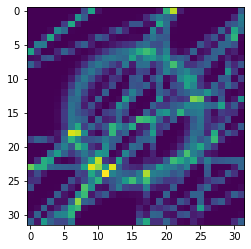

In [6]:
plt.imshow(observation_o[observation_key][0])

In [7]:
simulator = swyft.Simulator(
    simulator,
    ["x1", "y1", "r"],
    sim_shapes=observation_shapes
)

## prior, storage, additive noise model, and dataset

We include the noise model with the dataset so that every draw from the dataset has different noise. It is a form of data augmentation.

In [8]:
store = swyft.Store.memory_store(simulator)

Creating new store.


In [9]:
def noise(obs, v, sigma=0.1):
    mu = obs[observation_key]
    n = np.random.randn(*mu.shape)*sigma
    x = mu + n
    return dict(x=x)

In [10]:
low = np.zeros(n_parameters)
high = np.array([1., 1., 0.5])
prior = swyft.get_uniform_prior(low, high)
store.add(n_training_samples, prior)
store.simulate()

Store: Adding 99444 new samples to simulator store.


In [11]:
dataset = swyft.Dataset(
    n_training_samples, 
    prior, 
    store, 
    simhook=noise
)

## Define the network architechture

We will create a function to instantiate networks appropriate for our data. This function is very similar to the convenience function `swyft.networks.classifier.get_marginal_classifier`. 

The most natural way to design neural networks for `swyft` is to create functions which process hyperparameters and output instantiated `torch.nn.Modules`. We recommend using the `swyft.networks.classifier.Network` class to simplify the network design process. The necessary data processing required for `swyft` is automatically done in `Network`.

In [12]:
class CustomObservationTransform(torch.nn.Module):
    def __init__(self, observation_key: str, observation_shapes: dict):
        super().__init__()
        self.observation_key = observation_key
        self.n_features = 160  # This attribute must be defined!
        
        self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(observation_shapes)
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(10, 20, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(20, 40, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
        )

    def forward(self, obs: dict) -> torch.Tensor:
        x = self.online_z_score(obs)
        x = x[self.observation_key]
        return self.net(x)


def get_custom_marginal_classifier(
    observation_key: str,
    marginal_indices: tuple,
    observation_shapes: dict,
    n_parameters: int,
    hidden_features: int,
    num_blocks: int,
    parameter_online_z_score: bool = True,
) -> torch.nn.Module:
    observation_transform = CustomObservationTransform(observation_key, observation_shapes)
    n_observation_features = observation_transform.n_features

    parameter_transform = swyft.networks.ParameterTransform(
        n_parameters, marginal_indices, online_z_score=parameter_online_z_score
    )
    n_marginals, n_block_parameters = parameter_transform.marginal_block_shape

    marginal_classifier = swyft.networks.MarginalClassifier(
        n_marginals,
        n_observation_features + n_block_parameters,
        hidden_features=hidden_features,
        num_blocks=num_blocks,
    )

    return swyft.networks.Network(
        observation_transform,
        parameter_transform,
        marginal_classifier,
    )

## Train a 1d marginal estimator

In [13]:
network_1d = get_custom_marginal_classifier(
    observation_key=observation_key,
    marginal_indices=marginal_indices_1d,
    observation_shapes=observation_shapes,
    n_parameters=n_parameters,
    hidden_features=32,
    num_blocks=2,
)

mre_1d = MarginalRatioEstimator(
    marginal_indices=marginal_indices_1d,
    network=network_1d,
    device=device,
)

In [14]:
mre_1d.train(dataset, max_epochs=2)

training: lr=0.0005, epoch=2, validation loss=1.759

## Create a simple violin plot to view the 1d marginals

In [15]:
n_rejection_samples = 5_000

posterior_1d = swyft.MarginalPosterior(mre_1d, prior)
samples_1d = posterior_1d.sample(n_rejection_samples, observation_o)

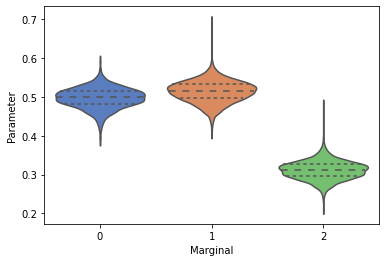

In [16]:
_ = swyft.violin(samples_1d)